 # Automated Image Classification using Advanced Deep Learning Models

 Group number 2: Renee DeMaio

 The goal for this Lab is it to provide you understanding of the various deep learning models that we will be using in your project(s). In this Lab we will implement VGG Architecture over CUB200-2011 dataset:

 The CUB200-2011 dataset can be found on its [website](https://paperswithcode.com/dataset/cub-200-2011). We can either use the data zip file or import it using  [Kaggle](https://www.kaggle.com) and [kaggle-api](https://github.com/Kaggle/kaggle-api) which needs to be installed with `pip install kaggle`. I would prefer all of you do this using Google Colab. This will also help you with Last 3 Labs.

  ## Data Preprocessing
 ### Downloading and extracting custom datasets
 ### Loading custom datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries and Set Random Seed

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, top_k_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 1), "GB")
    print("Cached:", round(torch.cuda.memory_reserved(0)/1024**3, 1), "GB")

Using device: cuda
NVIDIA L4
Memory Usage:
Allocated: 0.0 GB
Cached: 0.0 GB


In [3]:
def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(7598)

In [4]:
# Set Data folders, TensorDatasets and DataLoaders for the datasets

import os
import shutil
from tqdm import tqdm

source_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled"
train_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/train"
test_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/test"
val_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/val"
output_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/output_images"


 ### Calculating the mean and std for normalization on custom datasets


Commented this out because it takes two hours to run on colab. Results are in the transformations below.

In [11]:
# from pathlib import Path
# import cv2
# import numpy as np
# from tqdm import tqdm

# train_dir = Path(r'/content/drive/MyDrive/DSAN_6500/lab_7to9/cub2002011_dataset/train')
# files = list(train_dir.rglob('*.png'))

# mean = np.array([0., 0., 0.])
# stdTemp = np.array([0., 0., 0.])
# std = np.array([0., 0., 0.])

# numSamples = len(files)

# for i in range(numSamples):
#     im = cv2.imread(str(files[i]))
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     im = im.astype(float) / 255.

#     for j in range(3):
#         mean[j] += np.mean(im[:, :, j])

# mean = (mean / numSamples)

# for i in range(numSamples):
#     im = cv2.imread(str(files[i]))
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     im = im.astype(float) / 255.
#     for j in range(3):
#         stdTemp[j] += ((im[:, :, j] - mean[j]) ** 2).sum() / (im.shape[0] * im.shape[1])

# std = np.sqrt(stdTemp / numSamples)

# print(f"Calculated Mean: {mean}")
# print(f"Calculated Standard Deviation: {std}")

### Loading transforms to augment and normalize our data

In [5]:
from PIL import Image

batch_size = 64
numworkers = 2

# the below function tranforms and normalises the data

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.48801502, 0.50715263, 0.43608612], [0.23610121, 0.23127311, 0.27457839])
])

train_dataset = datasets.ImageFolder(train_dir, transform = transform)
test_dataset = datasets.ImageFolder(test_dir, transform = transform)
validation_dataset = datasets.ImageFolder(val_dir, transform = transform)

train_loader = DataLoader(train_dataset,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = numworkers)

test_loader = DataLoader(test_dataset,
                          batch_size = batch_size,
                          shuffle = False,
                          num_workers = numworkers)

validation_loader = DataLoader(validation_dataset,
                          batch_size = batch_size,
                          shuffle = False,
                          num_workers = numworkers)

#### Handling Class Weights

In [ ]:
#import os
#from collections import Counter
#
#def count_images_in_directories(root_dir):
#    class_counts = Counter()
#
#    for class_name in os.listdir(root_dir):
#        class_dir = os.path.join(root_dir, class_name)
#        if os.path.isdir(class_dir):
#            num_images = len(os.listdir(class_dir))
#            class_counts[class_name] = num_images
#
#    return class_counts
#
#root_dir = '../data/sampled/train'
#class_counts = count_images_in_directories(root_dir)
#
#print(class_counts)

In [76]:
class_counts = {'No Finding': 4503, 'Infiltration': 1503, 'Effusion': 1035, 'Atelectasis': 886,
                    'Nodule': 475, 'Mass': 417, 'Pneumothorax': 415, 'Consolidation': 360,
                    'Pleural_Thickening': 248, 'Cardiomegaly': 213, 'Edema': 194, 'Emphysema': 189,
                    'Pneumonia': 106, 'Fibrosis': 103, 'Hernia': 21}

num_samples = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = {class_name: num_samples / (num_classes * count) for class_name, count in class_counts.items()}
class_indices = {class_name: idx for idx, class_name in enumerate(class_counts.keys())}
training_weights = torch.tensor([class_weights[class_name] for class_name in class_indices.keys()], dtype=torch.float).to(device)

  ## Defining a Convolutional Neural Network
 ### Defining the VGG blocks
 ### Defining a CUB200-2011 VGG model

In [53]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc = "Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    return epoch_loss

In [54]:
def compute_metrics(labels, predictions, probs):
    metrics = {
        "Accuracy" : accuracy_score(labels, predictions),
        "Top-5 Accuracy" : top_k_accuracy_score(labels, probs, k = 5),
        "Macro Precision" : precision_score(labels, predictions, average = "macro"),
        "Weighted Precision" : precision_score(labels, predictions, average = "weighted"),
        "Macro Recall" : recall_score(labels, predictions, average = "macro"),
        "Weighted Recall" : recall_score(labels, predictions, average = "weighted"),
        "Weighted F1-Score" : f1_score(labels, predictions, average = "weighted"),
        # "Weighted AUC Score" : roc_auc_score(labels, probs, multi_class = "ovr", average = "weighted"),
        # "Weighted Mean Average Precision" : average_precision_score(labels, probs, average = "weighted")
    }

    return metrics

In [55]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc = "Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(nn.Softmax(dim = 1)(outputs).cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total

    metrics = compute_metrics(all_labels, all_predictions, all_probs)

    return epoch_loss, accuracy, metrics

In [56]:
from typing import Any

class EarlyStopping:
    def __init__(self, patience = 5, verbose = False, delta = 0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            if self.best_loss is not None:
                print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model ...")
            else:
                print(f"Saving model with validation loss {val_loss:.6f} ...")
        torch.save(model.state_dict(), "best_model.pth")
        self.best_loss = val_loss

 ## Training a Convolutional Neural Network
 ### Loading a pre-trained model
 ### Loading pre-trained model parameters into a defined model
 ### Learning rate finder
 ### Discriminative fine-tuning
 ### One cycle learning rate scheduler

In [57]:
VGGpretrained = torchvision.models.vgg16(pretrained= True)

VGGpretrained.classifier[6] = nn.Linear(in_features=4096, out_features=15, bias=True)

cuda = torch.cuda.is_available()

if cuda:
 VGGpretrained.cuda()

print(VGGpretrained)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [77]:
optimizer = optim.AdamW(params=VGGpretrained.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight = training_weights)

In [78]:
num_epochs = 40
patience = 5
early_stopping = EarlyStopping(patience = patience, verbose = True)

train_losses = []
val_losses = []
val_accuracies = []
metrics_list = []

for epoch in range(num_epochs):
    train_loss = train(VGGpretrained, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, metrics = evaluate(VGGpretrained, validation_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    metrics_list.append(metrics)

    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    for metric_name, metric_value in metrics.items():
        print(f"{metric_name} : {metric_value:.4f}")

    early_stopping(val_loss, VGGpretrained)

    if early_stopping.early_stop:
        print("Early stopping")
        break

Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/40, Train Loss: 1.7523, Val Loss: 2.4115, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.7241
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
Saving model with validation loss 2.411516 ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.29it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/40, Train Loss: 1.6942, Val Loss: 2.4861, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.7452
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
EarlyStopping counter: 1 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/40, Train Loss: 1.6955, Val Loss: 2.4933, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.6711
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
EarlyStopping counter: 2 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/40, Train Loss: 1.6907, Val Loss: 2.3959, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.7452
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
Validation loss decreased (2.411516 --> 2.395942). Saving model ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/40, Train Loss: 1.6949, Val Loss: 2.4751, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.7452
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
EarlyStopping counter: 1 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.29it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6/40, Train Loss: 1.6950, Val Loss: 2.3770, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.6711
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
Validation loss decreased (2.395942 --> 2.377031). Saving model ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.29it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7/40, Train Loss: 1.6995, Val Loss: 2.3571, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.7452
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
Validation loss decreased (2.377031 --> 2.357052). Saving model ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8/40, Train Loss: 1.6945, Val Loss: 2.4707, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.6711
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
EarlyStopping counter: 1 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9/40, Train Loss: 1.7001, Val Loss: 2.4043, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.7241
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
EarlyStopping counter: 2 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.29it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10/40, Train Loss: 1.6903, Val Loss: 2.4136, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.6711
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
EarlyStopping counter: 3 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11/40, Train Loss: 1.6941, Val Loss: 2.4194, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.6711
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
EarlyStopping counter: 4 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.31it/s]

Epoch: 12/40, Train Loss: 1.6933, Val Loss: 2.4435, Val Accuracy: 42.34%
Accuracy : 0.4234
Top-5 Accuracy : 0.6711
Macro Precision : 0.0282
Weighted Precision : 0.1793
Macro Recall : 0.0667
Weighted Recall : 0.4234
Weighted F1-Score : 0.2519
EarlyStopping counter: 5 out of 5
Early stopping



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 ## Evaluating a Convolutional Neural Network

Using the pre-trained model

In [80]:
class VGGalter(nn.Module):

  def __init__(self):
    super().__init__()

    self.VGG =  torchvision.models.vgg16(pretrained= True)
    self.VGG.features[30] = nn.MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)

    self.FC4 = nn.Sequential(
        nn.ReLU(inplace = True),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features=1000, out_features=200, bias=True)
    )


  def forward(self, x):

    x = self.VGG.features(x)
    x = self.VGG.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.VGG.classifier(x)

    x = self.FC4(x)

    return x


ComplexVGG = VGGalter()


cuda = torch.cuda.is_available()


if cuda:
 ComplexVGG.cuda()

print(ComplexVGG)

VGGalter(
  (VGG): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [81]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/vgg_metrics.csv", index = False)

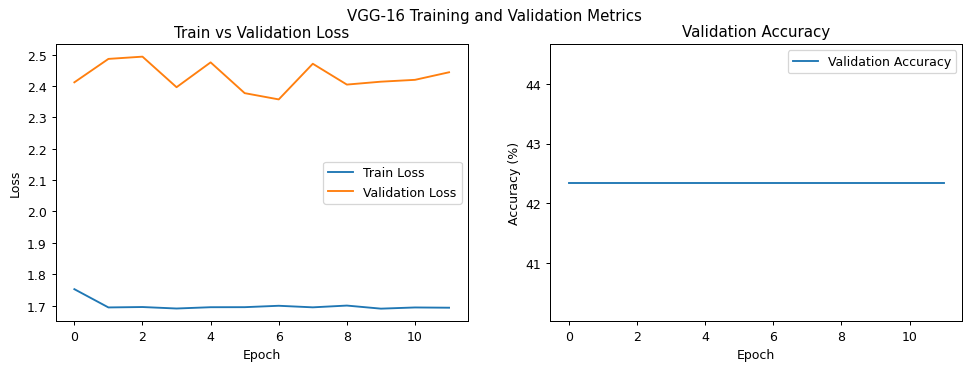

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize = (13, 4), dpi = 90)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label = "Train Loss")
plt.plot(val_losses, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.suptitle("VGG-16 Training and Validation Metrics")
plt.savefig("/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/output_images/vgg_train_val_metrics.jpg", dpi = 300)
plt.show()

In [83]:
test_loss, test_accuracy, test_metrics = evaluate(VGGpretrained, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
for metric_name, metric_value in test_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

Evaluating: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s]

Test Loss: 2.4784, Test Accuracy: 41.97%
Accuracy: 0.4197
Top-5 Accuracy: 0.6674
Macro Precision: 0.0280
Weighted Precision: 0.1761
Macro Recall: 0.0667
Weighted Recall: 0.4197
Weighted F1-Score: 0.2481



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 ### Viewing our model's mistakes

In [84]:
def display_random_images(model, test_dataset, dataset_classes, num_images = 12):
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_images)
    images, labels = zip(*[test_dataset[i] for i in indices])
    images = torch.stack(images).to(device)
    labels = torch.tensor(labels).to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy().transpose((0, 2, 3, 1))
    images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    images = np.clip(images, 0, 1)

    fig, axes = plt.subplots(4, 3, figsize = (12, 12))
    axes = axes.flatten()
    for img, true_label, pred_label, ax in zip(images, labels, predicted, axes):
        ax.imshow(img)
        ax.set_title(f"True: {dataset_classes[true_label]} \nPred: {dataset_classes[pred_label]}", color = '#009878' if true_label == pred_label else "#9C3839")
        ax.axis("off")

    plt.tight_layout()
    plt.suptitle("VGG-16 Image Prediction", fontsize=14, y=1.02)
    plt.savefig("/content/drive/MyDrive/DSAN_6500/lab_7to9/cub2002011_dataset/output_images/vgg_image_prediction.jpg", dpi = 300)
    plt.show()

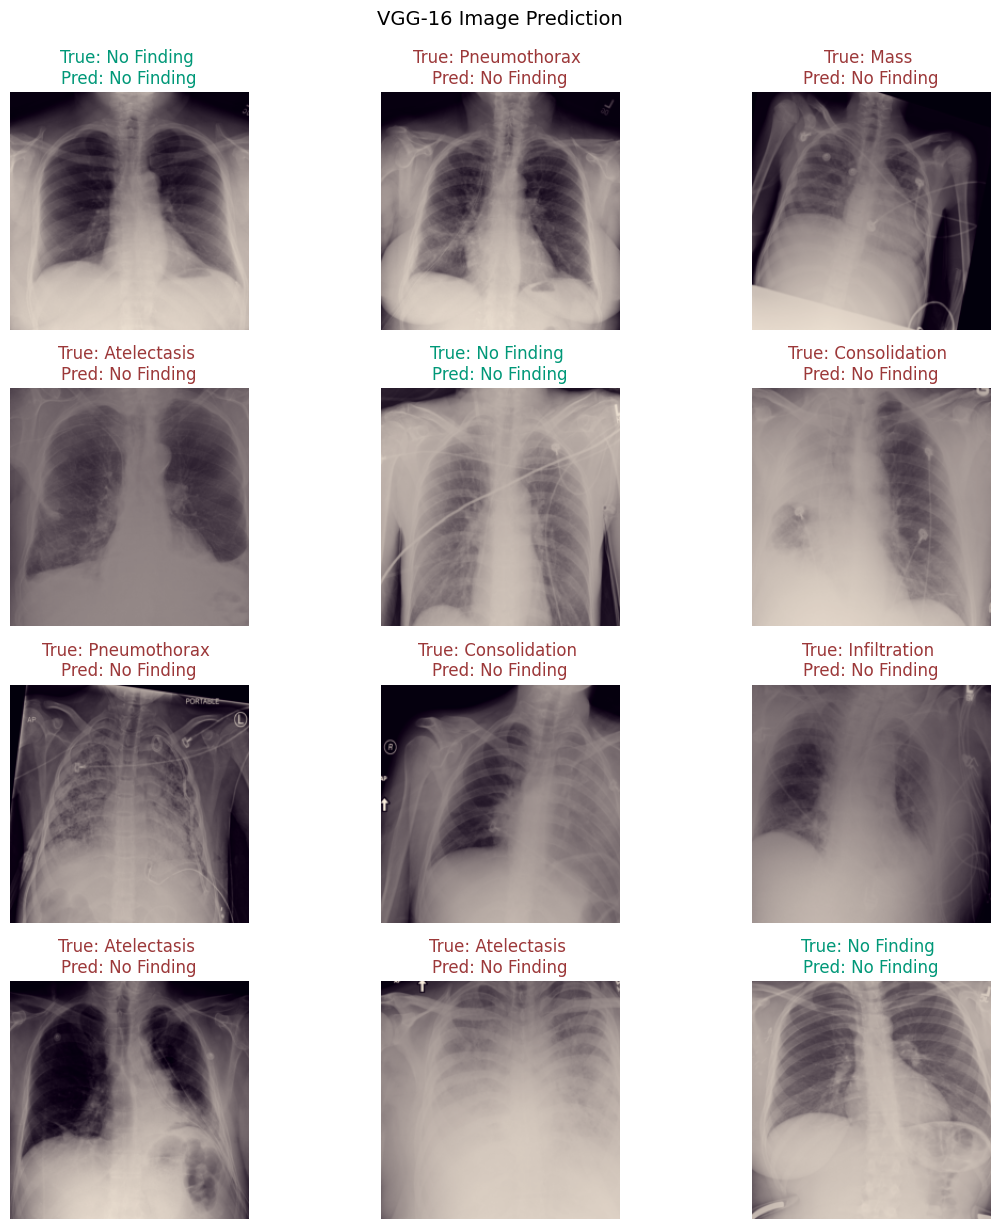

In [85]:
display_random_images(VGGpretrained, test_dataset, test_dataset.classes)

### Confusion Matrix


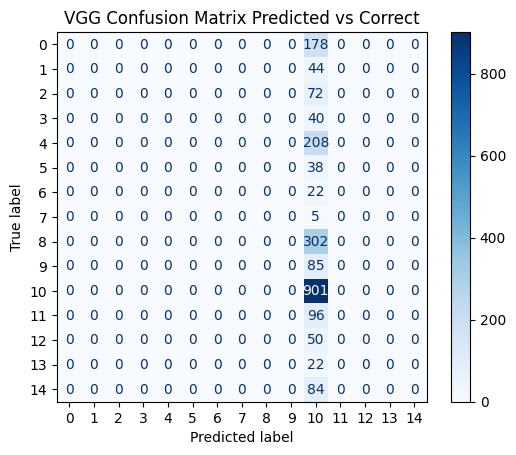

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGGpretrained.to(device)

VGGpretrained.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = VGGpretrained(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.title("VGG Confusion Matrix Predicted vs Correct")
plt.savefig("/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/output_images/vgg_cm.jpg", dpi = 300)
plt.show()